In [2]:
pip install tensorflow


^C
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/pip/__main__.py", line 22, in <module>
    from pip._internal.cli.main import main as _main
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/autocompletion.py", line 10, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/cli/main_parser.py", line 9, in <module>
    from pip._internal.build_env import get_runnable_pip
  File "/opt/conda/lib/python3.10/site-packages/pip/_internal/build_env.py", line 15, in <module>
    from pip.

# **1-VERİ ÖNİŞLEME**

## Yapay Sinir Ağı (ANN) ile Görüntü Sınıflandırma

Bu projede bir görüntü veri seti üzerinde yapay sinir ağı (ANN) kullanarak sınıflandırma işlemi gerçekleştireceğiz. İlk adımda veri önişleme işlemleri yapılarak görüntüler model için uygun formata getirilecektir.

## Veri Önişleme
Veri setimiz, klasörlerde yer alan `.png` formatında görüntülerden oluşmaktadır. Görüntüleri işleyip numpy array'e dönüştürüp normalizasyon işlemi uygulayacağız. Etiketler ise sayısal değerlere çevrilecek ve one-hot encoding işlemi yapılacaktır.

### Gerekli Kütüphanelerin Yüklenmesi
Veri işleme, model eğitimi ve görselleştirme işlemleri için gerekli kütüphaneleri yüklüyoruz.

### Görüntülerin İşlenmesi
Bu adımda görüntü dosyalarını okuyarak hedef boyutta yeniden boyutlandırıp numpy array formatına dönüştürüyoruz. Aynı zamanda görüntüleri normalize ederek modelin verimli bir şekilde öğrenmesini sağlıyoruz.

### Etiketlerin İşlenmesi
Veri setindeki sınıf etiketleri metin formatında olduğundan, bunları sayısal değerlere çevirip one-hot encoding ile modelin kullanabileceği formata dönüştürüyoruz.

### Veri Setini Bölme
Veri setini eğitim, doğrulama (validation) ve test setleri olarak ayırıyoruz. Eğitim sırasında validation seti ile model performansını kontrol edebileceğiz.


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Veri seti dizini
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Etiketler ve dosya yollarını depolamak için listeler oluştur
label = []
path = []

# Klasörlerdeki tüm dosyaları taramak için os.walk kullanılır
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        # Eğer dosya .png formatında ise
        if os.path.splitext(filename)[-1] == '.png':
            if 'GT' not in dir_name.split(os.sep):  # Eğer dizin adı 'GT' içermiyorsa
                label.append(os.path.split(dir_name)[-1])  # Etiketi dizin adından ayıkla
                path.append(os.path.join(dir_name, filename))  # Dosya yolunu ekle

# Pandas DataFrame oluştur (yol ve etiketlerle)
data = pd.DataFrame({'path': path, 'label': label})

# Veri çerçevesinin ilk birkaç satırını kontrol et
print(data.head())



                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


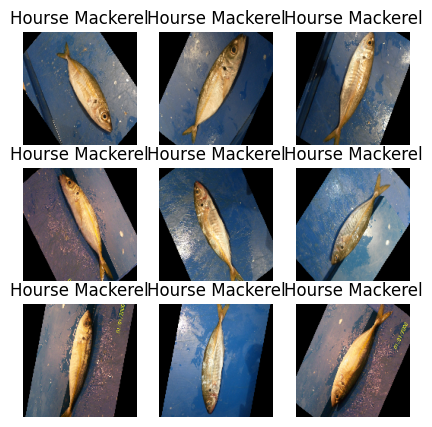

In [9]:
# Görsellerin örneklerini görselleştirme
plt.figure(figsize=(5, 5))
for i in range(9):
    img = load_img(data['path'].iloc[i], target_size=(150, 150))  # Görüntüyü yükle ve boyutlandır
    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(data['label'].iloc[i])
    plt.axis('off')
plt.show()


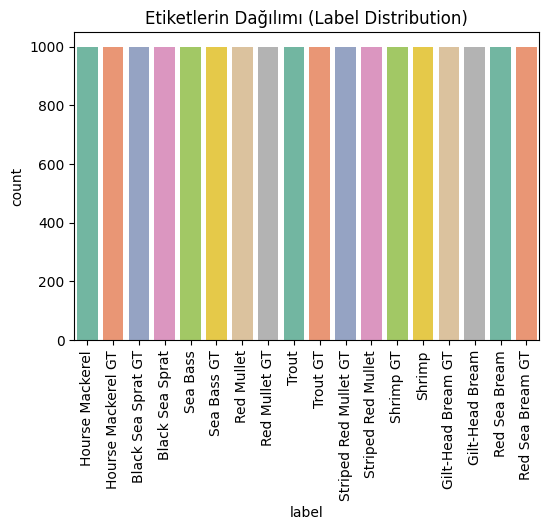

In [8]:
# Etiketlerin dağılımını görselleştirme
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, palette='Set2')
plt.title('Etiketlerin Dağılımı (Label Distribution)')
plt.xticks(rotation=90)  # Etiketlerin okunabilir olması için döndürme
plt.show()


# **2-ANN MODEL**

## Yapay Sinir Ağı (ANN) Modelinin Eğitimi

Bu aşamada yapay sinir ağı (ANN) modelini oluşturarak eğitim sürecini başlatacağız.

### ANN Modeli Oluşturma
Modelde giriş katmanı, gizli katmanlar ve çıkış katmanı bulunuyor. İlk katmanda görüntüler düzleştiriliyor (flatten). Gizli katmanlarda dropout katmanları ekleyerek overfitting'i engellemeye çalışıyoruz. Son katman ise sınıfları temsil eden softmax aktivasyon fonksiyonuna sahip.

### Modelin Derlenmesi
Modeli `Adam` optimizasyon algoritması ve `categorical_crossentropy` kayıp fonksiyonu ile derliyoruz. Ayrıca, doğruluk (`accuracy`) metriğini takip edeceğiz.

### Modeli Eğitme
Modeli belirlenen epoch sayısı boyunca eğitiyoruz. Eğitim esnasında, doğrulama (validation) seti ile modelin performansını izliyoruz.


In [13]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.optimizers import Adam

# Görüntüleri numpy array'e çevir ve boyutlandır
def process_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(150, 150))  # Görüntüleri yeniden boyutlandır
        img = img_to_array(img)  # Görüntüyü diziye çevir
        img /= 255.0  # Normalizasyon
        images.append(img)
    return np.array(images)

# Görüntüleri işleme
X = process_images(data['path'].values)

# Etiketleri sayısal değerlere çevirme
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'].values)

# Sınıfları one-hot encoding ile kategorik hale getirme
y = to_categorical(y)

# Veriyi eğitim ve test setine bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ANN modeli oluşturma
model = Sequential()

# İlk katman olarak Input kullanıyoruz (Flatten ile 2D görüntüleri düzleştiriyoruz)
model.add(Input(shape=(150, 150, 3)))
model.add(Flatten())

# Gizli katmanlar (Dense katmanlar) ekleniyor
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Overfitting'i azaltmak için dropout kullanıyoruz
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Çıkış katmanı
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modeli eğitme
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 190s 417ms/step - accuracy: 0.0865 - loss: 6.8121 - val_accuracy: 0.1142 - val_loss: 2.6926
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 182s 403ms/step - accuracy: 0.0946 - loss: 2.7864 - val_accuracy: 0.1553 - val_loss: 2.5171
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 184s 410ms/step - accuracy: 0.0997 - loss: 2.6924 - val_accuracy: 0.1486 - val_loss: 2.4449
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 221s 452ms/step - accuracy: 0.1146 - loss: 2.5603 - val_accuracy: 0.1647 - val_loss: 2.2395
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 185s 410ms/step - accuracy: 0.1395 - loss: 2.3955 - val_accuracy: 0.1597 - val_loss: 2.1698
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 185s 411ms/step - accuracy: 0.1398 - loss: 2.3414 - val_accuracy: 0.1664 - val_loss: 2.0912
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 206s 457ms/step - accuracy: 0.1452 - loss: 2.2904 - val_accuracy: 0.1689 - val_loss: 2.1743
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 242s 412ms/step - accuracy: 0.1528 -

# **3-DEĞERLENDİRME**

## Model Performansının Değerlendirilmesi

Modeli eğittikten sonra, eğitim ve doğrulama (validation) setleri üzerinde doğruluk (accuracy) ve kayıp (loss) değerlerini grafiklerle karşılaştıracağız.

### Eğitim ve Doğrulama Performansı Görselleştirme
Modelin eğitim sürecindeki doğruluk ve kayıp değerlerini görselleştirerek modelin ne kadar iyi öğrendiğini ve olası overfitting sorunlarını inceleyeceğiz.

### Test Seti Üzerinde Değerlendirme
Modelimizi test seti üzerinde çalıştırarak nihai doğruluğunu elde edeceğiz.

### Piksel Yoğunluğunun Görselleştirilmesi
Görüntülerdeki piksel yoğunluğunu inceleyerek veri setimizin genel dağılımını görselleştiriyoruz. Bu, veri setindeki piksel dağılımını anlamamıza yardımcı olur.

### Etiket Dağılımının Görselleştirilmesi
Veri setimizdeki sınıfların dağılımını gösteren bir grafiği çizerek, veri setinin dengeli olup olmadığını kontrol ediyoruz.


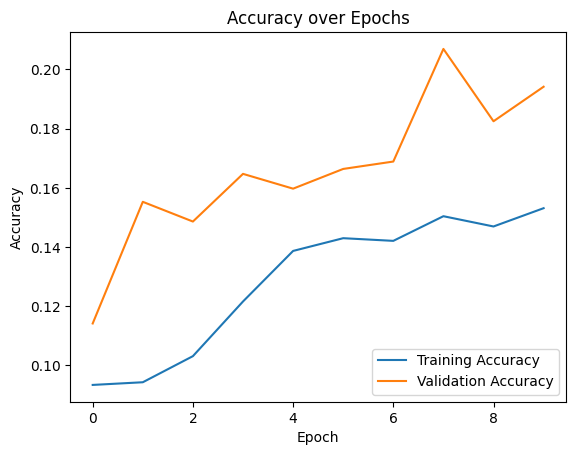

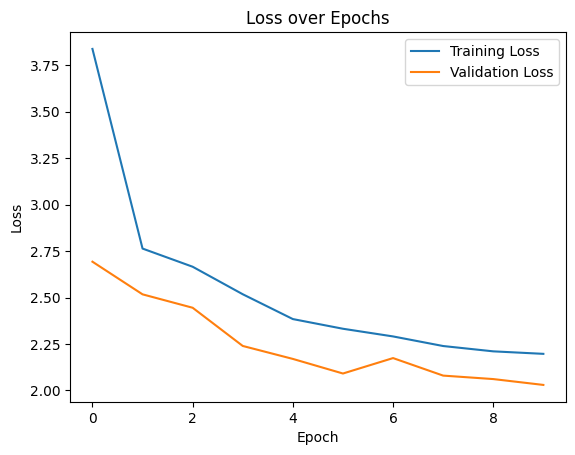

113/113 - 4s - 37ms/step - accuracy: 0.1942 - loss: 2.0299
Test Doğruluğu: 0.1941666603088379
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step


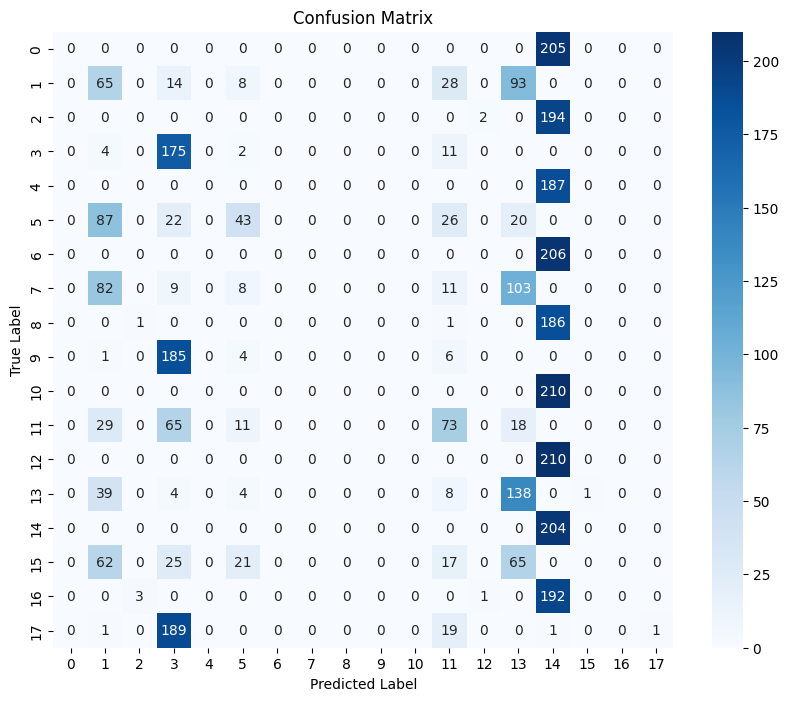

Classification Report:
                       precision    recall  f1-score   support

      Black Sea Sprat       0.00      0.00      0.00       205
   Black Sea Sprat GT       0.18      0.31      0.22       208
      Gilt-Head Bream       0.00      0.00      0.00       196
   Gilt-Head Bream GT       0.25      0.91      0.40       192
      Hourse Mackerel       0.00      0.00      0.00       187
   Hourse Mackerel GT       0.43      0.22      0.29       198
           Red Mullet       0.00      0.00      0.00       206
        Red Mullet GT       0.00      0.00      0.00       213
        Red Sea Bream       0.00      0.00      0.00       188
     Red Sea Bream GT       0.00      0.00      0.00       196
             Sea Bass       0.00      0.00      0.00       210
          Sea Bass GT       0.36      0.37      0.37       196
               Shrimp       0.00      0.00      0.00       210
            Shrimp GT       0.32      0.71      0.44       194
   Striped Red Mullet       0.1

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# Eğitim ve doğrulama doğruluğunu görselleştirme
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy over Epochs')
plt.show()

# Eğitim ve doğrulama kaybını görselleştirme
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss over Epochs')
plt.show()

# Test doğruluğunu göster
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Doğruluğu: {test_acc}')

# Confusion Matrix ve Classification Report
from sklearn.metrics import confusion_matrix, classification_report

# Test setine tahminlerde bulun
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
